# DAT801, Oppgave 2 - Prosjekt Fantasy Premier League

Lill-Kristin Karlsen, 16.11.2021

# Beskrivelse av prosjektet.

-	Prosjektet skal se på muligheten for å innføre Fantasy Premier League som en betalingstjeneste, med en utbetalings- og gevinstmodell for topp 500 spillere hver uke, i tillegg gi muligheter for å kunne satse penger innad i spillet ved å satse på hvor mange poeng en spiller oppnår i hver runde. Maskinlæringsmodellen vil beregne optimal forventet poengsum for hver runde utifra all statistikk lastet ned fra FPL(features), og oddsberegninger vil bli gjort på grunnlag av dette datamaterialet. Modellen skal løse et regresjonsproblem.

-	 Med over 8 millioner aktive spillere i sesongen 21/22, antas dette å skape lønnsomhet selv om andeler av gratisbrukere i dag ikke skulle være interessert i å videreføre sitt medlemskap i Fantasy Premier League, dersom betaling avkreves. Det er naturlig å tro at et høyt antall spillere vil være interesserte i å videreføre sine abonnement, mot et antatt rimelig vederlag.

- Det er lite trolig at en slik beregning kunne blitt gjort manuelt hver uke. Det er store mengder data som predikasjoner skal beregnes på, og det er et tidsintervall involvert i dette med tanke på at modellen må oppdateres med nye resultater tilnærmet hver uke, så lenge sesongen pågår. Man ville muligens kunne benyttet scripts som kunne beregne tilsvarende mtp sannsynlighet.

- Modellens treffsikkerhet vil hver uke kunne være direkte målbar ved å sammenligne forventet høyeste poengsum (label), og faktisk høyeste poengsum en spiller oppnådde med "business metrics", som feks kvadratiske avvik. Det vil være viktig å minke feilmarginen på modellen, da unøyaktighet i oddsberegning vil kunne øke kostnader for prosjektet i drift. 

- Det vil være behov for å teste latency og throughput for modellen(e) når all data er akkumulert og ferdigbehandlet, for å teste modellens ytelse og eventuelt tilpasse maskinvare og modell for å kunne levere predikasjoner innenfor en akseptabel tidsramme. Dette vil gjøres under modellbygging i testmiljø, på samme mengde data som forventes brukt i produksjon. 

- En betalingsløsning vil måtte implementeres i bunn av maskinlæringsløsningen, da utbetalinger vil foregå som et ledd i beregninger gjort av modellen. Endringer på modellen må kvalitetssikres gjennom alle ledd av en transaksjon. 

- Det vil være behov for investorer i prosjektet, for å få finansert utvikling av modellen, innkjøp/utvikling av betalingsløsning, innkjøp av maskinvare, sertifikater for sikker kommunikasjon, lisenser, juridisk ivaretagelse av personvernhensyn med tanke på kredittkortinformasjon m.m. Investorer vil, sammen med fremtidige brukere av løsningen, være stakeholders i prosjektet. 

- Det vil være behov for ansette ekstra personell, både utviklere og data scientists for å kunne implementere, validere og ivareta modellen i etterkant. Det vil også være behov for å ansette/leie inn juridisk personell for å vurdere og ivareta personvernregler og oppbevaring av personsensitive data. Det antas at infrastruktur personell allerede finnes.

- Etiske retningslinjer ifm pengespill må tas høyde for i prosjektet.

- Prosjektet anses å være en suksess dersom modellens predikasjoner fører til lønnsomhet over tid i sine oddsberegninger, slik at kostnader ved den totale driften dekkes. Det er en forutsetning at modellen har en lavest mulig feilmargin i sine predikasjoner. Det vil etter produksjonssetting være et mål å fortsette tuning av modellen i testmiljø med liveerfaringer, for å utvikle modellen til å bli mer selvlært og dermed oppnå lavere feilmarging.




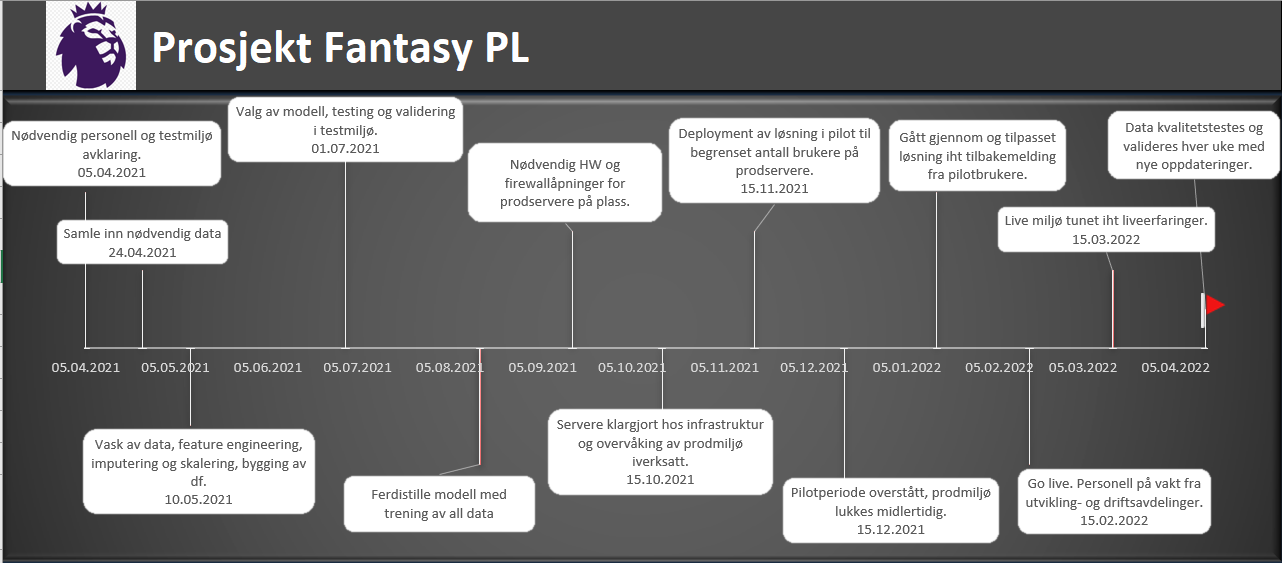

# Innhenting av data

1. Data vil samles inn fra FPLs eget api: https://fantasy.premierleague.com/api/bootstrap-static . 
2. Data samles ved å bruke request modulen i Python, konverteres deretter til en json fil, og konverteres så til Pandas Dataframes.
3. I denne modellen, så vil hver enkelt Premier League spillers totalsum i FPLpoeng (total_points) hver uke være target/label og målet med predikasjonene.
4. For å spare en del arbeid i forbindelse med denne prosjektoppgaven, vasking av data og bygging av korrekt dataframe, så vil jeg bruke et allerede sammensatt datasett fra https://github.com/vaastav/Fantasy-Premier-League i denne forbindelse. Det er likevel illustrert i oppgaven hvordan man ville kunne hente ned data fra Fantasy Premier League dersom man skulle satt sammen data selv i en dataframe. Man ville da ha måttet hente ut relevante features selv, sjekket korrelasjoner, undersøkt formatet til dataene og eventuelt konvertert dem til tall(eller droppet feature), og om det fantes NaN verdier som måtte imputeres. Modellvalg ville også avgjort behovet for skalering og type skalering.

In [30]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
url = "https://fantasy.premierleague.com/api/bootstrap-static/" # illustrerer produksjon.

In [ ]:
r = requests.get(url) #illustrasjon produksjon
json = r.json() 
json.keys() 

In [31]:
NB_DIR = Path.cwd()
DATA = NB_DIR/'data'
DATA.mkdir(exist_ok=True)

Denne oppgaven bruker Gameweek 11 data som illustrasjonsgrunnlag for predikering, optimalt sett ville man brukt all data tilgjengelig fra alle gameweeks. Da ville man slått sammen alle gameweeks både fra forrige sesonger og denne, i tillegg ville jeg lagt inn motstanderlagets oppnådde poeng i samme kamper. Dette ville blitt gjort i en produksjonsutgave av denne modellen.

# Inspiserer og tilrettelegger data for modellering. 

1. Modellen som kommer til å bli brukt er RandomForestRegressor. 

2. Bruker Mean Squared Error (MSE) og Mean Absolute Error (MAE) for å måle treffsikkerheten til modellen, da det ikke går an å måle accuracy på et regresjonsproblem på samme måte som ved et klassifiseringsproblem. Det tas også høyde for outliners i datasettet ved beregningen av feilmargin, samt ekstra validering ved bruk av oob_score som bruker data som ikke har vært med i trærnes bagging og decisionmaking, til å validere resultat. 

3. Basline-ytelse vil kunne være direkte målbart fra uke til uke, ved at man sammenligner faktiske resultat oppnådd i FPL, mot prediksjoner som ble gjort av modellen.

4. Plottene (under) som viser hvilke features som gir lavere MSE, kan brukes til å forbedre modellen ved features engineering, ved at man vektlegger disse under modellbygging.


In [32]:
train = pd.read_csv("gw11.csv") # Denne filen er clonet fra https://github.com/vaastav/Fantasy-Premier-League

In [ ]:
train.shape

In [ ]:
print(train.columns)

In [ ]:
train.sort_values(by=["total_points"], ascending=False)

In [33]:
X = train.drop(["total_points", "name", "position", "team", "kickoff_time", "was_home"], axis = 1) #for enkelhetens skyld, dropper jeg disse features i tillegg til label, som jeg ellers ville konvertert til fra strenger til tall, dersom det var ønskelig å ha dem med.

In [34]:
y = train["total_points"].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42 )

In [36]:
regr = RandomForestRegressor(oob_score = True, n_estimators = 100000, max_features = 5)

In [ ]:
regr.fit(X_train, y_train)

In [38]:
predict_train = regr.predict(X_train)

In [39]:
predict_test = regr.predict(X_test)

In [40]:
out_of_bag_predict = regr.oob_score #her brukes data som ikke har vært med i trærnes bagging og decisionmaking, til å validere resultat.

In [41]:
residuals = predict_train - y_train
residuals2 = predict_test - y_test
residuals3 = out_of_bag_predict - y_train
mse_train = np.sqrt(sum(residuals**2)/len(residuals))
mse_test = np.sqrt(sum(residuals2**2)/len(residuals2))
mse_out_of_bag = np.sqrt(sum(residuals3**2)/len(residuals3))
abs_train = sum(abs(residuals))/len(residuals)
abs_test = sum(abs(residuals2))/len(residuals2)
abs_out_of_bag = sum(abs(residuals3))/len(residuals3)

In [ ]:
print("sqrt(MSE) on train set: ", mse_train)
print("sqrt(MSE) on test set: ", mse_test)
print("Mean Absolute value of residuals on train set: ", abs_train)
print("Mean Absolute value of residuals on test set: ", abs_test)

Her defineres en variabel for å se features utifra hvor lavere feilmargin de gir, altså hvor viktige de er. Plottene under illustrerer hvilke features som gir lavest feilmargin i predikasjoner.

In [42]:
importances = regr.feature_importances_ 

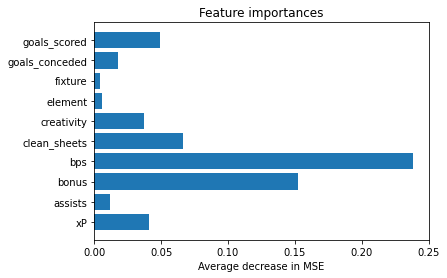

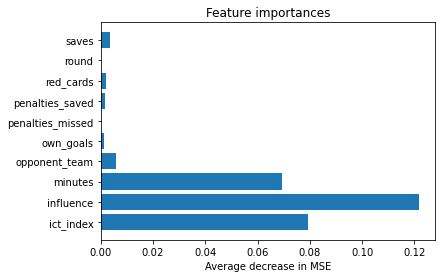

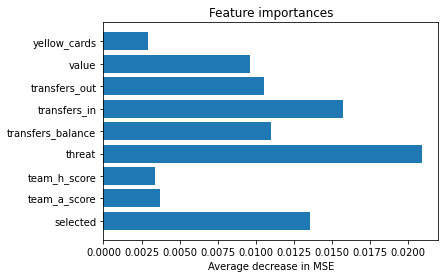

In [43]:
for i in range(0,30,10):
    plt.figure()
    plt.title("Feature importances")
    ax = plt.barh(list(X_train.columns)[i:i+10],importances[i:i+10],align="center");
    plt.xlabel('Average decrease in MSE');

In [ ]:
list(zip(y_test, predict_test)) #sammenligner labels fra y_test og predikerte resultater.

Til slutt ville man kjørt en ny trening med all data, for å kunne predikere på mest mulig data. Om man ønsker, så kan man sette sammen en ny dataframe med name, posisjon, lag og lagt til "predicted_points" til dataframen som en ekstra kolonne. Det er illustrert under.

In [ ]:
finaldf = train[["name", "position", "team"]]

In [ ]:
finaldf['predicted_points'] = y_pred.tolist()

# Deployment

Når en maskinlæringsmodell skal deployes, er det nødvendig å ha tatt stilling til følgende spørsmål:

- Hvor ofte skal predikasjoner fra modellen utføres?
- Skal predikasjoner gjøres for en eller flere instanser?
- Hvor mange applikasjoner skal bruke modellen?
- Finnes det krav til latency?

Disse spørsmålene vil danne grunnlag for hvordan en maskinlæringsmodell kan deployes. 

- For dette prosjektet, vil predikasjoner ikke være tilgjengeliggjort for brukerne direkte, men kan kjøres 1 gang pr uke og mellomlagres.

- Kravet til latency/kjøretid på beregning av predikasjoner har derfor lavere terskel enn om de skulle vært tilgjengeliggjort for brukerne direkte. Akseptabel tidsramme er derimot likevel begrenset, da kunder ikke kan satse på oddsen før nye predikasjoner er gjort mellom hver runde i PL, og lang latency vil bety mulig tapte inntekter. 

- Predikasjoner skal kun brukes av applikasjonen som beregner oddsutbetalinger, og det anses derfor naturlig at disse kan lagres i en database som kan gjøres uttrekk fra.

- Databaseserveren som skal inneha data fra maskinlæringsmodellen bør infrastrukturmessig være plassert samme sted som applikasjonen som skal bruke informasjonen til oddsberegninger, for å ivareta sikkerhet, informasjonsflyt og svartid.

- Det vil i dette prosjektet brukes servere on-prem, grunnet krav til personvern og sikkerhet. All trafikk mellom ulike instanser vil være kryptert. Det vil derfor i forkant gjøres et fullstendig design av servere som inngår i løsningen, samt testing av all informasjonsflyt mellom de ulike komponentene i produksjonsmiljøet i samråd mellom utviklere, data scientists og infrastruktur personell. 

- Ref milepælplan, så vil produksjonsmiljøet være overvåket. Det vil være triggere både oppetid på servere, tilgjengelighet av database, generelle infrastrukturkomponenter, tilgang til ny data gjennom api, samt det vil etter hver ny kjøring av predikasjoner, kjøres kvalitetssikring av data og features, samt en sammenligning opp imot faktiske resultater fra hver FPL runde. Modellens lønnsomhet vil vurderes fortløpende.

- Det er lagt til grunn en piloteringsfase i produksjonsmiljøet med et begrenset antall brukere, for å teste og eventuelt avdekke eventuelle forbedringsområder i produksjon, slik det er tenkt "live". Det er satt av tid i prosjektet til å utbedre disse, før løsningen åpnes i fullskala.

# Referanser

https://fantasy.premierleague.com/

https://towardsdatascience.com/fantasy-premier-league-value-analysis-python-tutorial-using-the-fpl-api-8031edfe9910

https://github.com/vaastav/Fantasy-Premier-League

https://machinelearningmastery.com/regression-metrics-for-machine-learning/

https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

https://www.kdnuggets.com/2020/02/deploy-machine-learning-model.html

https://github.com/francescobarbara/FPL-point-predictor-via-random-forests

https://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html